In [3]:
from modules import *
import json
import plotly.graph_objects as go
import numpy as np

# Obtenemos datos json con 25 elementos = vanos

path = "../data/"

with open(path+'vanos.json', 'r') as archivo:
    data = json.load(archivo)
    
len(data)
data.remove(data[2])

In [4]:
def get_coord(points):
    
    x_vals = [punto[0] for punto in points]
    y_vals = [punto[1] for punto in points]
    z_vals = [punto[2] for punto in points]
    
    return np.stack(x_vals), np.stack(y_vals), np.stack(z_vals)

def get_coord2(extremos_apoyos):
    
    x_vals = [extremos_apoyos[0]["COORDENADA_X"], extremos_apoyos[0]["COORDENADA_X"], extremos_apoyos[1]["COORDENADA_X"], extremos_apoyos[1]["COORDENADA_X"]]
    y_vals = [extremos_apoyos[0]["COORDEANDA_Y"], extremos_apoyos[0]["COORDEANDA_Y"], extremos_apoyos[1]["COORDEANDA_Y"], extremos_apoyos[1]["COORDEANDA_Y"]]
    z_vals = extremos_apoyos[0]["COORDENADAS_Z"] + extremos_apoyos[1]["COORDENADAS_Z"]

    return np.stack(x_vals), np.stack(y_vals), np.stack(z_vals)

def add_plot(fig, data, color, size, name, mode):
    
    fig.add_trace(go.Scatter3d(
        x=data[0],
        y=data[1],
        z=data[2],
        mode=mode,
        marker=dict(
            size=size,
            color=color,  # Color de los apoyos
        ),
        name=name  # Nombre de la traza de los apoyos
    ))
    
def extract_vano_values(data, vano):
    
    puntos_conductores = data[vano]['LIDAR']['CONDUCTORES']
    puntos_apoyos = data[vano]['LIDAR']['APOYOS']
    extremos_apoyos = data[vano]['APOYOS']
        
    # puntos_vertices = np.concatenate([element['VERTICES'] for element in data[vano]['CONDUCTORES']])
    
    # Extrae las coordenadas x, y, z de los conductores

    x_vals_conductores, y_vals_conductores, z_vals_conductores = get_coord(puntos_conductores)
    x_vals_apoyos, y_vals_apoyos, z_vals_apoyos = get_coord(puntos_apoyos)
    x_vals_extremos, y_vals_extremos, z_vals_extremos = get_coord2(extremos_apoyos)
    
    cond_values = [x_vals_conductores, y_vals_conductores, z_vals_conductores]
    apoyo_values = [x_vals_apoyos, y_vals_apoyos, z_vals_apoyos]
    extremos_values = [x_vals_extremos, y_vals_extremos, z_vals_extremos]
    
    vert_values = []
    
    for element in data[vano]['CONDUCTORES']:
        vert_values.append(get_coord(element['VERTICES']))
    
    return cond_values, apoyo_values, vert_values, extremos_values

In [5]:
def plot_data(cond_values, apoyo_values, vert_values, extremos_values):

    # Crea el gráfico para los conductores
    fig = go.Figure(data=[go.Scatter3d(
        x=cond_values[0],
        y=cond_values[1],
        z=cond_values[2],
        mode='markers',
        marker=dict(
            size=2.5,
            color='blue',  # Color de los conductores
        ),
        name='Conductores'  # Nombre de la traza de los conductores
    )])

    # Agrega el gráfico para los apoyos
    add_plot(fig, apoyo_values, "orange", 2.5, "Apoyos", "markers")
    
    # Agrega el gráfico para los extremos
    add_plot(fig, extremos_values, "black", 5, "Extremos", "markers")
    
    
    for vert in vert_values:
    
        # Agrega el gráfico para los vertices
        add_plot(fig, vert , "red", 5, "Vertices", "lines")

    # Agrega títulos a los ejes
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        margin=dict(r=0, b=0, l=0, t=0)  # Reduce el margen alrededor del gráfico
    )

    # Muestra el gráfico
    fig.show()

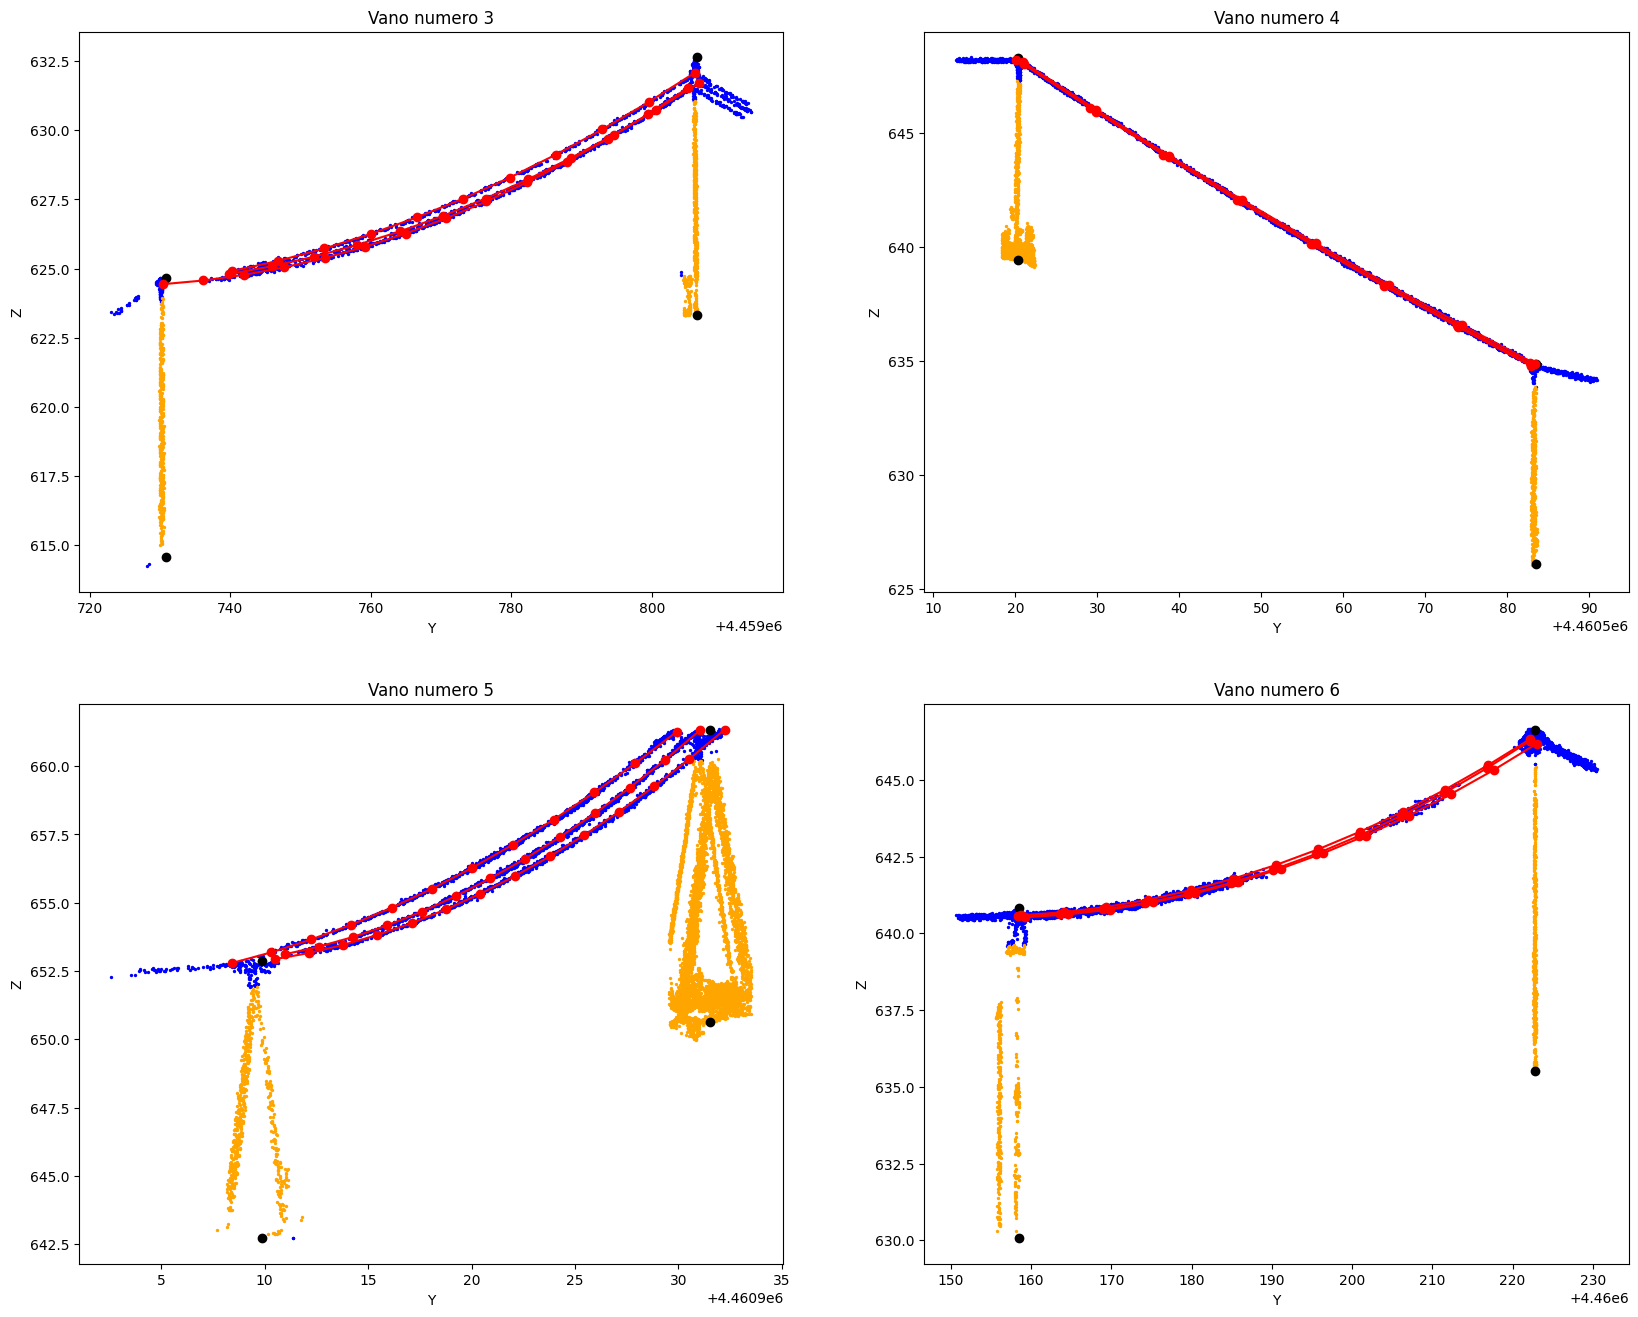

In [6]:
#VISUALIZZO LINEA in 2 D
import matplotlib.pyplot as plt

# Crea un grafico 2D
plt.figure(figsize=(20, 16))

j = 0

for i in range(25)[3:7]:
    
    j += 1
    
    cond_values, apoyo_values, vert_values, extremos_values = extract_vano_values(data, i)

    plt.subplot(2,2, j)

    plt.scatter(cond_values[1], cond_values[2], color='blue', s = 2)
    plt.scatter(apoyo_values[1], apoyo_values[2], color='orange', s = 2)
    plt.scatter(extremos_values[1], extremos_values[2], color='black')
    
    for vert in vert_values:
        plt.plot(vert[1], vert[2],"-o", color='red')

    # Etichette degli assi
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title(f'Vano numero {i}')

# Mostra il grafico
plt.show()

In [7]:
def rotate_points(points, extremos_values):
    
    points = np.array(points).T

    extremo1 = np.array(extremos_values).T[0]  # Extremo superior del primer poste
    extremo2 = np.array(extremos_values).T[2]  # Extremo inferior del primer poste
    
    # Calcular la distancia en el plano XY y la dirección de la diagonal
    distancia_xy = np.linalg.norm(extremo2[:2] - extremo1[:2])
    direccion_diagonal = (extremo2[:2] - extremo1[:2]) / distancia_xy # Normalizada para la distancia
    
    # Calcular el ángulo de rotación necesario para alinear la diagonal con el eje Y
    angulo = np.arctan2(direccion_diagonal[1], direccion_diagonal[0])
    
    # Ajustar el ángulo para la rotación correcta
    angulo += np.pi / 2
    c, s = np.cos(angulo), np.sin(angulo)
    
    # Crear la matriz de rotación para alinear la diagonal con el eje Y
    matriz_rotacion = np.array([[c, s, 0],
                                [-s, c, 0],
                                [0, 0, 1]])
    
    rotated_points = matriz_rotacion.dot(points.T)
    # print(rotated.shape)
    
    return matriz_rotacion, np.array(rotated_points)

Distancia x e y: (75.12199999950826, 21.665999999269843)
Distancia xz, xy e yz: (75.53449361825407, 78.18395257272735, 23.055593642504782)
Distancia 3D: 78.58037466272623


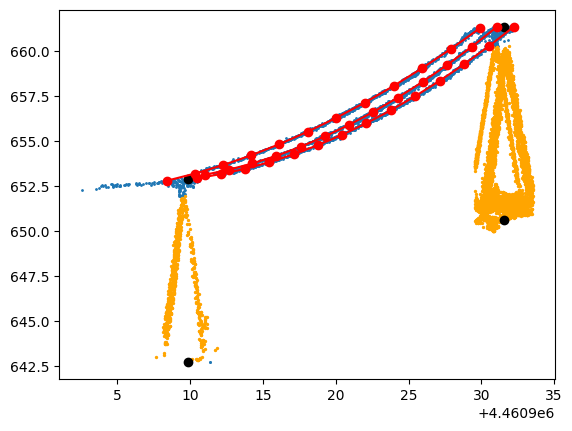

Distancia x e y: (9.313225746154785e-10, 78.18395257275552)
Distancia xz, xy e yz: (7.883199999996577, 78.18395257275552, 78.58037466275425)
Distancia 3D: 78.58037466275425


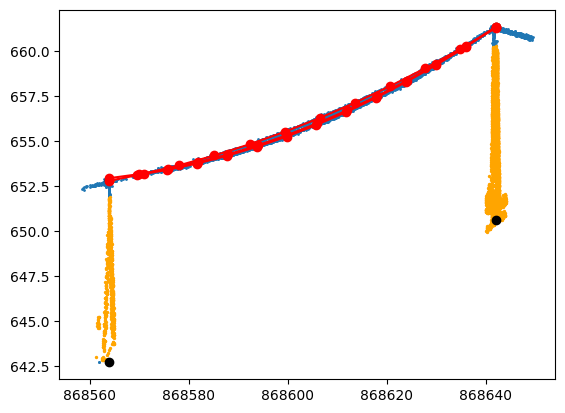

In [8]:
def rotate_vano(cond_values, extremos_values, apoyo_values, vert_values):

    # Rotate and compare
    mat, rotated_conds = rotate_points(cond_values, extremos_values)

    rotated_apoyos = mat.dot(apoyo_values)
    rotated_extremos = mat.dot(extremos_values)
    rotated_vertices = [mat.dot(vert) for vert in vert_values]
    
    return rotated_conds, rotated_apoyos, rotated_vertices, rotated_extremos

cond_values, apoyo_values, vert_values, extremos_values = extract_vano_values(data, 5)

plt.scatter(np.array(cond_values)[1], np.array(cond_values)[2], s = 1)
plt.scatter(apoyo_values[1], apoyo_values[2], color='orange', s = 2)
plt.scatter(extremos_values[1], extremos_values[2], color='black')

for vert in vert_values:
    plt.plot(vert[1], vert[2],"-o", color='red')

x_apoyos_distance, y_apoyos_distance, xz_distance, xy_distance, yz_distance, D3_apoyos_distance = get_distances(extremos_values)

print(f"Distancia x e y: {x_apoyos_distance, y_apoyos_distance}")
print(f"Distancia xz, xy e yz: {xz_distance, xy_distance, yz_distance}")
print(f"Distancia 3D: {D3_apoyos_distance}")

plt.show()

rotated_conds, rotated_apoyos, rotated_vertices, rotated_extremos = rotate_vano(cond_values, extremos_values, apoyo_values, vert_values)

plt.scatter(rotated_conds[1], rotated_conds[2], s = 1)
plt.scatter(rotated_apoyos[1], rotated_apoyos[2], color='orange', s = 2)
plt.scatter(rotated_extremos[1], rotated_extremos[2], color='black')
    
for vert in rotated_vertices:
    plt.plot(vert[1], vert[2],"-o", color='red')

x_apoyos_distance, y_apoyos_distance, xz_distance, xy_distance, yz_distance, D3_apoyos_distance = get_distances(rotated_extremos)

print(f"Distancia x e y: {x_apoyos_distance, y_apoyos_distance}")
print(f"Distancia xz, xy e yz: {xz_distance, xy_distance, yz_distance}")
print(f"Distancia 3D: {D3_apoyos_distance}")

Umbral de corte superior detectado: 868641.2276929405


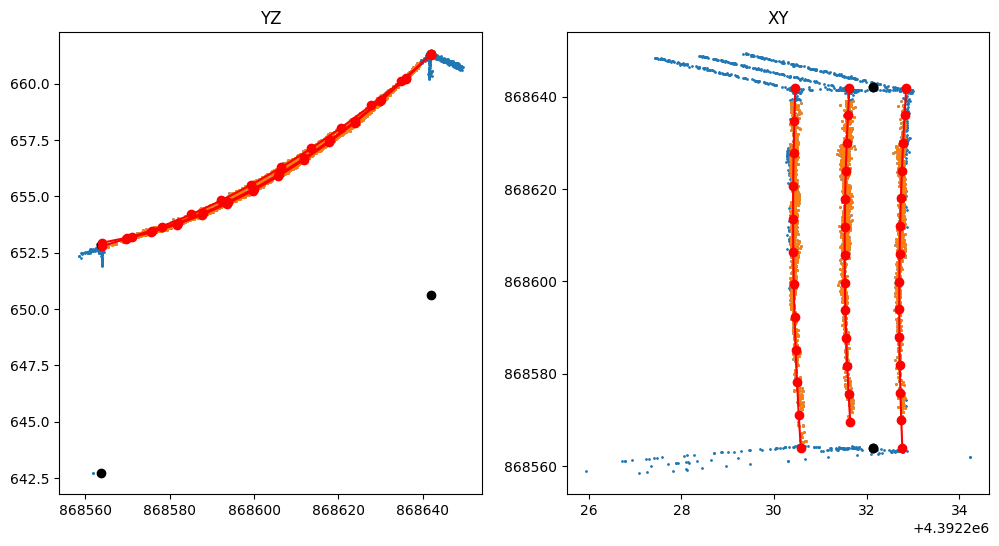

In [9]:
def clean_outliers(rotated_conds, rotated_extremos):

    # Get top and bottom extreme values
    top = np.max([rotated_extremos.T[1][2],rotated_extremos.T[3][2]])
    bottom = np.max([rotated_extremos.T[0][2],rotated_extremos.T[2][2]])

    #Get left and right extreme values
    left = np.max([rotated_extremos.T[2][1],rotated_extremos.T[3][1]])
    right = np.min([rotated_extremos.T[0][1],rotated_extremos.T[1][1]])

    # Filter points within the specified boundaries
    cropped_conds = rotated_conds[:, (right > rotated_conds[1,:]) & (rotated_conds[1,:] > left)]
    # cropped_conds = cropped_conds[:, (top > cropped_conds[2,:]) & (cropped_conds[2,:] > bottom)]
    
    # Paso 1: Calcular el histograma de las coordenadas Y
    hist, bin_edges = np.histogram(cropped_conds[1, :], bins=100)

    # Paso 2: Identificar los picos significativos en ambos extremos del histograma
    # Definir un umbral para considerar un pico significativo
    threshold_density = np.mean(hist) + 3 * np.std(hist)

    # Encontrar el bin con la mayor cantidad de puntos en la parte superior
    peak_bin_upper = np.argmax(hist[:len(hist)//2])
    # Encontrar el bin con la mayor cantidad de puntos en la parte inferior
    peak_bin_lower = np.argmax(hist[len(hist)//2:]) + len(hist)//2

    # Inicializar los umbrales
    threshold_y_upper = None
    threshold_y_lower = None

    # print(hist[peak_bin_upper], hist[peak_bin_lower], threshold_density)
    # plt.hist(cropped_conds[1, :], bins = 100)
    
    # Verificar si hay una línea horizontal significativa en la parte superior
    if hist[peak_bin_upper] > threshold_density:
        threshold_y_upper = bin_edges[peak_bin_upper]  # El +1 es para obtener el borde superior del bin
        print(f"Umbral de corte inferior detectado: {threshold_y_upper}")

    # Verificar si hay una línea horizontal significativa en la parte inferior
    if hist[peak_bin_lower] > threshold_density:
        threshold_y_lower = bin_edges[peak_bin_lower]  # No se necesita ajustar más
        print(f"Umbral de corte superior detectado: {threshold_y_lower}")

    # Paso 3: Filtrar los puntos usando los umbrales detectados
    if threshold_y_upper is not None:
        cropped_conds = cropped_conds[:, cropped_conds[1, :] > threshold_y_upper]

    if threshold_y_lower is not None:
        cropped_conds = cropped_conds[:, cropped_conds[1, :] < threshold_y_lower]
    
    # # Calcular percentiles 1 y 99
    p1 = np.percentile(cropped_conds[1, :], 2)
    p99 = np.percentile(cropped_conds[1, :], 98)

    # Filtrar los datos para eliminar el 5% de los puntos con menor y mayor coordenada Y
    cropped_conds = cropped_conds[:,(cropped_conds[1, :] > p1) & (cropped_conds[1, :] < p99)]
        
    # Erase X axis outliers
    p1 = np.percentile(cropped_conds[0, :], 2)
    p99 = np.percentile(cropped_conds[0, :], 98)
    
    cropped_conds = cropped_conds[:,(cropped_conds[0, :] > p1) & (cropped_conds[0, :] < p99)]

    return cropped_conds

cropped_conds = clean_outliers(rotated_conds, rotated_extremos)

plt.figure(figsize=(12,6))

plt.subplot(121)
plt.scatter(rotated_conds[1], rotated_conds[2], s = 1, label = "Original Conductors")
plt.scatter(cropped_conds[1], cropped_conds[2], s = 1, label = "Cropped Conductors")

plt.scatter(rotated_extremos[1], rotated_extremos[2], color='black')
for vert in rotated_vertices:
    plt.plot(vert[1], vert[2],"-o", color='red')
plt.title("YZ")

plt.subplot(122)
plt.scatter(rotated_conds[0], rotated_conds[1], s = 1, label = "Original Conductors")
plt.scatter(cropped_conds[0], cropped_conds[1], s = 1, label = "Cropped Conductors")

plt.scatter(rotated_extremos[0], rotated_extremos[1], color='black')
for vert in rotated_vertices:
    plt.plot(vert[0], vert[1],"-o", color='red')
plt.title("XY")

plt.show()

In [11]:
len(rotated_vertices), rotated_vertices[0].shape

(3, (3, 12))

In [21]:
n_vanos = len(data)
poli_errors = []

for i in range(n_vanos):
    
    print(f"\nProcessing Vano {i}")
    
    cond_values, apoyo_values, vert_values, extremos_values = extract_vano_values(data, i)
    
    rotated_conds, rotated_apoyos, rotated_vertices, rotated_extremos = rotate_vano(cond_values, extremos_values, apoyo_values, vert_values)
    
    cropped_conds = clean_outliers(rotated_conds, rotated_extremos)
    
    real_length_2d = data[i]["LONGITUD_2D"]
    
    poli_lengths_2d = []

    for vert in rotated_vertices:
        poli_lengths_2d.append(abs(np.min(vert[1]) - np.max(vert[1])))
        
    # cond_length_2d = abs(np.min(cropped_conds[1]) - np.max(cropped_conds[1]))

    max_2d_error = 100*abs(real_length_2d-min(poli_lengths_2d))/real_length_2d
    poli_errors.append(max_2d_error)
    
    print(f"Max 2d error: {max_2d_error}")
    print(f"Real length vs min poli length: {real_length_2d, min(poli_lengths_2d)}")



Processing Vano 0
Umbral de corte superior detectado: 3970051.0719417185
Max 2d error: 3.1611113263612634
Real length vs min poli length: (30.689231010239173, 29.71911025280133)

Processing Vano 1
Umbral de corte inferior detectado: 4030235.2944142018
Umbral de corte superior detectado: 4030297.426474936
Max 2d error: 1.3313963889864453
Real length vs min poli length: (73.97219393890238, 72.98733081994578)

Processing Vano 2
Umbral de corte inferior detectado: 4012870.1276257066
Umbral de corte superior detectado: 4012949.4435723266
Max 2d error: 0.8082542925318092
Real length vs min poli length: (80.12791401818157, 79.48027671361342)

Processing Vano 3
Umbral de corte superior detectado: 4096857.914611348
Max 2d error: 12.65986171869595
Real length vs min poli length: (79.78287877162056, 69.68247664393857)

Processing Vano 4
Umbral de corte inferior detectado: 4014641.69218957
Umbral de corte superior detectado: 4014708.7109918348
Max 2d error: 2.0905333644967006
Real length vs min p

(array([16.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.]),
 array([ 0.80825429, 10.08816065, 19.36806701, 28.64797337, 37.92787973,
        47.20778609, 56.48769245, 65.76759881, 75.04750517, 84.32741153,
        93.60731789]),
 <BarContainer object of 10 artists>)

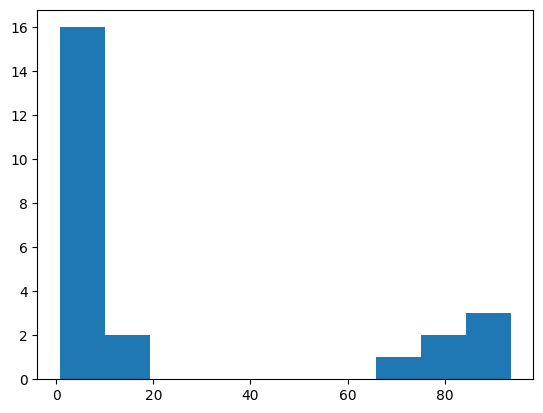

In [30]:
plt.hist(poli_errors)

In [35]:
np.mean(poli_errors), np.std(poli_errors)

np.where(poli_errors > np.mean(poli_errors) + np.std(poli_errors))[0]

array([11, 18, 19, 20, 21, 23])